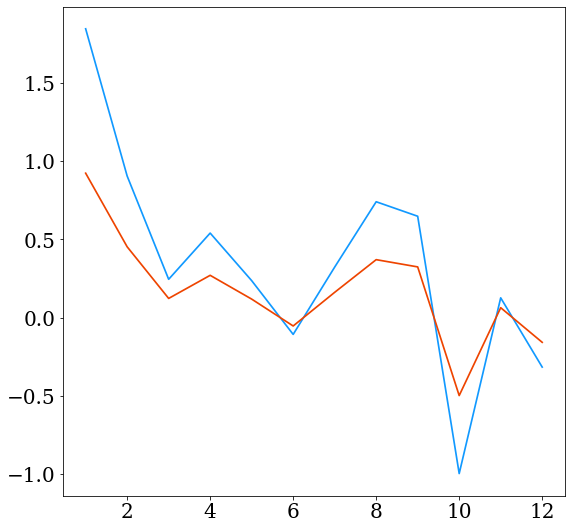

In [9]:
import os.path
import pickle
from pathlib import Path

import autofit as af
from matplotlib import pyplot as plt

from warm_pixels import hst_utilities as ut

data_directory = Path(os.path.abspath("")) / "data"


def load_data(name):
    with open(data_directory / f"{name}.pickle", "r+b") as f:
        return pickle.load(f)


date = load_data("date")
x = load_data("x")
y = load_data("y")
noise = load_data("noise")
n_e = load_data("n_e")
n_bg = load_data("n_bg")
row = load_data("row")

# CCD
beta = 0.478
w = 84700.0
# Trap species
a = 0.17
b = 0.45
c = 0.38
# Trap lifetimes before or after the temperature change
if date < ut.date_T_change:
    tau_a = 0.48
    tau_b = 4.86
    tau_c = 20.6
else:
    tau_a = 0.74
    tau_b = 7.70
    tau_c = 37.0


plt.plot(x, y)

In [10]:

from autoarray.fit.fit_dataset import SimpleFit
from warm_pixels.hst_functions.trail_model import trail_model


class Analysis(af.Analysis):
    def __init__(self, x, y, noise, n_e, n_bg, row):
        self.x = x
        self.y = y
        self.noise = noise
        self.n_e = n_e
        self.n_bg = n_bg
        self.row = row

    def _model_trail(self, rho_q):
        return trail_model(
            self.x,
            rho_q,
            self.n_e,
            self.n_bg,
            self.row,
            beta,
            w, a, b, c,
            tau_a,
            tau_b,
            tau_c,
        )

    def visualize(self, paths, instance, during_analysis):
        plt.plot(self.x, self.y)
        plt.plot(self.x, self._model_trail(instance))

    def log_likelihood_function(self, instance):
        modelled_trail = self._model_trail(instance)
        fit = SimpleFit(
            data=self.y,
            model_data=modelled_trail,
            noise_map=self.noise,
        )
        return fit.log_likelihood

ImportError: cannot import name 'SimpleFit' from 'autoarray.fit.fit_dataset' (/Users/richardhayes/autolens/aarray/autoarray/fit/fit_dataset.py)

In [ ]:
rho_q_model = af.UniformPrior(
    lower_limit=0.0,
    upper_limit=10.0,
)
analysis = Analysis(
    x=x,
    y=y,
    noise=noise,
    n_e=n_e,
    n_bg=n_bg,
    row=row,
)

dynesty = af.DynestyStatic()

result = dynesty.fit(
    model=rho_q_model,
    analysis=analysis,
)